# What is a Bayes net?

A Bayes net - or Bayesian network - is a probabilistic graphical model, or PGM. It is a simple and intuitive way to represent a joint probability distribution by specifying conditional probability distributions for the underlying variables in the network. Bayes nets can represent both discrete and continuous variables, though we will focus initially on networks with only discrete variables. 

We'll use two toy examples to explore the implementation.

1. The alarm network: https://github.com/jpmcarrilho/AIMA/blob/master/probability-4e.ipynb 
    _The story, from Judea Pearl, is that there is a house burglar alarm, which can be triggered by either a burglary or an earthquake. If the alarm sounds, one or both of the neighbors, John and Mary, might call the owner to say the alarm is sounding._

2. This one also looked fun! https://www.cs.cmu.edu/afs/cs.cmu.edu/project/learn-43/lib/photoz/.g/web/glossary/bayesnet.html


# Representing a Bayes net in code

Conceptually a Bayes net is simple; all we need is the node mappings, or dependencies, and the probabilities that define the conditional / unconditional probability distributions.  

In terms of defining a structure, we will look to capture the key attributes.

|Attribute |Description| 
|-----|-----|
| _names_ |Maps a convenient shorthand node label to the to the full text e.g. A for Alarm  |
|_dependencies_|Maps nodes to their dependents |
|_parents_|Maps nodes to their parents |
|_conditional_probabilities_|Maps nodes to their conditional probabilities |
|_independent_nodes_|Set of nodes with no parents |
|_leaf_nodes_|Set of nodes with no dependencies |

We can use a dataclass to represent this structure for the two examples. In this case we are constructing the network manually, but later we will generalise the process such that the structure can be generated from a minimal representation i.e. the conditional probabilities. For now the conditional probabilities will be set as None.

In [351]:
from dataclasses import dataclass


@dataclass
class BayesNet:
    """Class for representing a Bayes net."""
    names: dict
    dependencies: dict
    parents: dict
    conditional_probabilities: dict
    independent_nodes: set
    leaf_nodes: set

In [352]:
bayesnet_alarm = BayesNet(names={
    'B': 'Burglary',
    'E': 'Earthquake',
    'A': 'Alarm',
    'M': 'Mary calls',
    'J': 'John calls'
},
    dependencies={
    'B': ['A'],
    'E': ['A'],
    'A': ['M', 'J']
},
    parents={
    'M': ['A'],
    'J': ['A'],
    'A': ['B', 'E']
},
    conditional_probabilities=None,
    independent_nodes={'B', 'E'},
    leaf_nodes={'M', 'J'})

In [353]:
bayesnet_mars = BayesNet(names={
    'V': 'Visited Mars',
    'C': 'Common cold',
    'M': 'Martian death flu',
    'R': 'Runny nose',
    'H': 'Headache',
    'S': 'Spontaneous combustion'
},
    dependencies={
    'V': ['M'],
    'M': ['R', 'H', 'S'],
    'C': ['R', 'H']
},
    parents={
    'R': ['C'],
    'H': ['C', 'M'],
    'S': ['M'],
    'M': ['V']
},
    conditional_probabilities=None,
    independent_nodes={'V', 'C'},
    leaf_nodes={'R', 'H', 'S'})

# Visualising a Bayes net

Seeing a network makes it easier to interpret. The package graphviz is a useful tool to help us; all we need to do is specify the nodes, and the edges between nodes, which we can extract from the attributes.

In [354]:
import graphviz

def visualise_bn(bn: BayesNet, use_full_names: bool):
    """Visualises Bayes net object."""
    g = graphviz.Digraph()
    for node, next_nodes in bn.dependencies.items():
        for nn in next_nodes:
            if use_full_names:
                g.edge(bn.names[node], bn.names[nn])
            else:
                g.edge(node, nn)
    return g

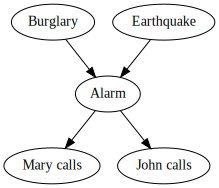

In [355]:
visualise_bn(bn=bayesnet_alarm, use_full_names=True)

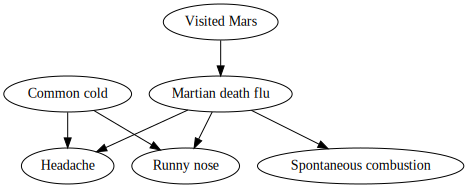

In [356]:
visualise_bn(bn=bayesnet_mars, use_full_names=True)

# Specifying the joint probability distribution via conditional probabilities

Thus far we've looked at Bayes nets as graphs, focusing on the nodes and the dependencies between nodes. The tricky bit of a Bayes net is how to succinctly and efficiently represent and work with the conditional probabilities. We can use a CSV format to specify the key information, which we have done for the key examples in data/conditional_probabilities_alarm.csv.

We read these into a Pandas data-frame: 

In [357]:
import pandas as pd
with open('../data/conditional_probabilities_alarm.csv', 'r') as f:
    conditional_probabilities_df_alarm = pd.read_csv(f)

conditional_probabilities_df_alarm

,node,probability,conditionals
0,B,0.001,None
1,E,0.002,None
2,A,0.950,B=T;E=T
3,A,0.940,B=T;E=F
4,A,0.290,B=F;E=T
5,A,0.001,B=F;E=F
6,J,0.900,A=T
7,J,0.050,A=F
8,M,0.700,A=T
9,M,0.010,A=F


Each distribution is specified on one row. For independent nodes - B & E - there is no conditioning, hence one line defines the complete and unconditional probability. A requires four rows, since it has two parent nodes, each of which can take two values. J and M each have one parent, so require two rows.

We have given minimal info thus far, and each row is implicitly a Bernoulli distribution, with the probability corresponding to the parameter generally taken as p. For the moment we will assume Bernoulli distributions, and examine later how we can generalise this.

# Simulating a Bayes net

This functionality is generally in line with the proof-of-concept Excel model. If you haven't seen that, it may be useful to take a look as that gives decent intuition into how and why the simulation functionality is set out.

## Random numbers

In [358]:
with open('../excel/fixed_random_numbers_100k.csv', 'r') as f:
    random_numbers = pd.read_csv(f)
N = random_numbers.shape[0]    
    
random_numbers = 1-random_numbers # to align Excel and ppf
random_numbers.head()

,B,E,A,M,J
0,0.946102,0.578330,0.741226,0.365127,0.833227
1,0.998269,0.157830,0.723855,0.279586,0.861028
2,0.537858,0.691179,0.728596,0.346864,0.346127
3,0.420817,0.045270,0.658436,0.841218,0.978299
4,0.762577,0.817734,0.442690,0.748229,0.558408


## Representing conditional distributions

In [359]:
from typing import Optional, List, Callable, Tuple

@dataclass
class ConditionalDistribution:
    """Class for representing a conditional distribution."""
    conditionals: Optional[List[Tuple[str,int]]]
    ppf: Callable
    

In [360]:
from scipy.stats import bernoulli

conditional_distributions = {
    'B': [ConditionalDistribution(conditionals=None,
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.001)).astype(int)
                                 )],
    'E': [ConditionalDistribution(conditionals=None,
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.002)).astype(int)
                                 )],
    'A': [ConditionalDistribution(conditionals=(('B', 0),('E', 0)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.001)).astype(int)
                                 ),
          ConditionalDistribution(conditionals=(('B', 0),('E', 1)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.29)).astype(int)
                                 ),
          ConditionalDistribution(conditionals=(('B', 1),('E', 0)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.94)).astype(int)
                                 ),
          ConditionalDistribution(conditionals=(('B', 1),('E', 1)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.95)).astype(int)
                                 )],
    'M': [ConditionalDistribution(conditionals=(('A', 0)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.01)).astype(int)
                                 ),
          ConditionalDistribution(conditionals=(('A', 1)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.7)).astype(int)
                                 )],
    'J': [ConditionalDistribution(conditionals=(('A', 0)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.05)).astype(int)
                                 ),
          ConditionalDistribution(conditionals=(('A', 1)),
                                  ppf = lambda x: (bernoulli.ppf(x, p=0.9)).astype(int)
                                 )]
}

## Ordering the simulation of variables

In [361]:
variables_order = ['B', 'E', 'A', 'M', 'J']

## Simulating independent variables

Independent variables can be simulated directly. We use the percentile-point function - or ppf - of the object to map the random number input into random variates of 1 and 0; these represent instances of where the variable has (1) or has not occurred (0).

We can demo this for the variables B and E. Starting with an empty dataframe, we iterate over the independent variables and join the output into a single dataframe.

In [362]:
random_variates = pd.DataFrame()
for var in ['B', 'E']:
    if len(conditional_distributions[var])==1:
        # no condtionals, append to existing output
        random_variates = pd.concat([random_variates,
                                     pd.DataFrame({var: conditional_distributions[var][0].ppf(random_numbers[var])})],
                                     axis=1)
    else:
        # to be defined
        pass
    
random_variates

,B,E
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


Due to the low probabilities that a burglary or earthquake occurs, the arrays are mostly zeros. We can sense check that the results are correct by summing the arrays. Given probabilities of 0.1% and 0.2%, respectively, for burglaries and earthquakes, we would expect sums of close to 10 and 20.

In [363]:
random_variates.sum()

B     91
E    194
dtype: int64

## Simulating conditional variables

Simulating conditional variables is a little more involved. We apply a two step approach, where we simluate conditional distributions as we did for the independent variables, but also use simulate the actual events. The latter requires the random variates constructed to date. 

We will demo this with the alarm variable, A.

In [364]:
var = 'A'

### Conditional random variates

Create a Pandas dataframe for each conditional distribution, using the list of conditionals as the column keys. There are lots of 1s, which indicate the alarm going off, but these are contingent on one or both of a burglary or earthquake occurring. 

In [365]:
conditional_random_variates = pd.concat([
    pd.DataFrame({cd.conditionals: cd.ppf(random_numbers[var])}) for cd in conditional_distributions[var]
], axis=1)

conditional_random_variates


(B, 0)        (B, 1)       
      (E, 0) (E, 1) (E, 0) (E, 1)
0          0      1      1      1
1          0      1      1      1
2          0      1      1      1
3          0      0      1      1
4          0      0      1      1
...      ...    ...    ...    ...
99995      0      0      1      1
99996      0      0      1      1
99997      0      0      1      1
99998      0      0      1      1
99999      0      1      1      1

[100000 rows x 4 columns]

In [366]:
conditional_random_variates.sum()

(B, 0)  (E, 0)      107
        (E, 1)    29109
(B, 1)  (E, 0)    94086
        (E, 1)    95103
dtype: int64

### Actual events

Use the same format - a Pandas dataframe with the conditionals as column keys - to create the array of actual events. This is again a series of 1s and 0s, but these represent whether a conditional event has occurred. e.g. whether there has been no burglary and no earthquake.

For this purpose we first define a separate function to generate the actual events.

In [367]:
def generate_actual_events(conditionals: List[Tuple[str,int]], random_variates: pd.DataFrame) -> np.array:
    """
    Given a list of conditional (variable, value) pairs and a dataframe of random variates (1s and 0s),
    this function generates flags for whether the conditional is met
    e.g. given [('B', 0),('E', 0)], the return value is 1 where B and E are 0, and 0 elsewhere.
    
    Return Numpy array of 1s and 0s.
    """
    number_conditionals = len(conditionals)
    number_variates = random_variates.shape[0]
    outcomes = np.zeros((number_variates,number_conditionals)).astype(int)
    for i,(variable, value) in enumerate(conditionals):
        outcomes[:,i] = (random_variates[variable]==value)*1

    return np.product(outcomes, axis=1)


assert np.all(generate_actual_events(conditionals=[('B', 0),('E', 0)], random_variates=pd.DataFrame({'B':[0, 0, 1, 1],
                                'E':[0, 1, 0, 1]})) == np.array([1, 0, 0, 0]))

Now apply the same pattern as before.

In [368]:
actual_events = pd.concat([
    pd.DataFrame({cd.conditionals: generate_actual_events(cd.conditionals, random_variates)}) for cd in conditional_distributions[var]
], axis=1)

actual_events


(B, 0)        (B, 1)       
      (E, 0) (E, 1) (E, 0) (E, 1)
0          1      0      0      0
1          1      0      0      0
2          1      0      0      0
3          1      0      0      0
4          1      0      0      0
...      ...    ...    ...    ...
99995      1      0      0      0
99996      1      0      0      0
99997      1      0      0      0
99998      1      0      0      0
99999      1      0      0      0

[100000 rows x 4 columns]

The count of actual events is another sense check. 99.7% of the time there is no burglary or earthquake.

In [369]:
actual_events.sum()

(B, 0)  (E, 0)    99715
        (E, 1)      194
(B, 1)  (E, 0)       91
        (E, 1)        0
dtype: int64

###  Multiply and row-sum

The final step is to multiply then row-sum the two dataframes together. Multiplying the two together gives the random variates for the variable, in this case the alarm, A. It is no longer conditional, since the actual events have acted as a filter, by zeroising all but one entry. It can be a little confusing that the entry which is not zeroised, may also be zero.

Applying a row-sum returns this as the simulated value for A. We can then join this to the independent random variates already created for B and E.

In [370]:
random_variates_A = pd.DataFrame({'A':(conditional_random_variates*actual_events).sum(axis=1)})
random_variates = pd.concat([random_variates, random_variates_A], axis=1)
random_variates.sum()

B     91
E    194
A    250
dtype: int64

In [371]:
random_variates = pd.DataFrame()
for var in ['B', 'E']:
    if len(conditional_distributions[var])==1:
        # no condtionals, append to existing output
        random_variates = pd.concat([random_variates,
                                     pd.DataFrame({var: conditional_distributions[var][0].ppf(random_numbers[var])})],
                                     axis=1)
    else:
        # to be defined
        pass
    
random_variates

,B,E
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


In [372]:

# random_variates = pd.DataFrame()
# for var in variables_order:
#     if len(conditional_distributions[var])==1:#.conditionals is None:
#         # no condtionals, append to existing output
#         random_variates = pd.concat([random_variates,
#                                      pd.DataFrame({var: conditional_distributions[var][0].ppf(random_numbers[var])})],
#                                      axis=1)
#     else:
#         # conditionals exist
#         # construct two x Numpy arrays: 
#         # - one for the conditional distributions
#         # - one for the outcomes of the conditionals based on radom variates (1/0 for whether the event occurred or not)
#         # multiply the arrays and return the sum over the column axis
#         # the summation effectively returns the conditional distribution for the event that occurred
#         # (note this implicitly assumes that conditionals are mutually exclusive, which should be the case)
#         conditional_random_variates = np.array(pd.concat([
#             pd.DataFrame(cd.ppf(random_numbers[var])) for cd in conditional_distributions[var]
#         ], axis=1))
#         outcomes = generate_outcomes(conditional_distributions[var].conditionals[i], random_variates)
#         random_variates = pd.concat([random_variates,
#                                      pd.DataFrame({var: np.product(conditional_random_variates*outcomes, axis=1)})],
#                                      axis=1)





# Parsing conditional probabilities to initialise a Bayes net

# Visualising results

# Inference from simulation

# Testing the implementation

# Extending the implementation